In [71]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [72]:
results_dir = Path("results/tiny")

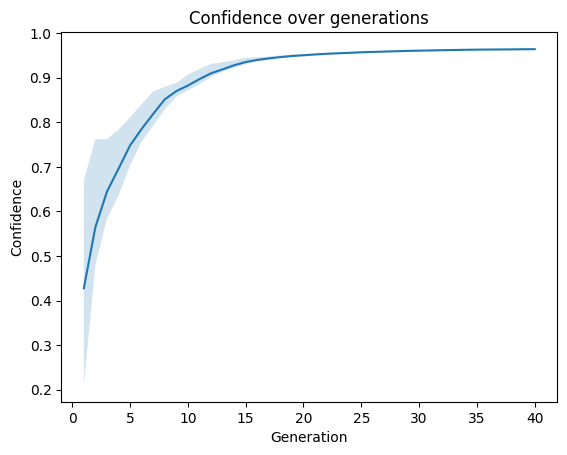

In [73]:
def plot_results(results_dirs: list[Path]):
    fig, ax = plt.subplots()

    for results_dir in results_dirs:
        gens = range(1, len(list(results_dir.glob("*.csv")))+1)

        worsts = []
        means = []
        bests = []

        for gen in gens:
            df = pd.read_csv(results_dir / f"{gen}.csv")
            worsts.append(-1 * df["acc"].max())
            means.append(-1 * df["acc"].mean())
            bests.append(-1 * df["acc"].min())

        ax.plot(gens, means)
        ax.fill_between(gens, worsts, bests, alpha=0.2)

    ax.set_title("Confidence over generations")
    ax.set_xlabel("Generation")
    ax.set_ylabel("Confidence")

    plt.show()

plot_results([results_dir])

In [74]:
import torch
from torch.utils.data import DataLoader, Subset
import yaml

from dataset import MNISTDataset
from evaluator import MNISTEvaluator
from prescriptor import DeepNNPrescriptorFactory

In [75]:
with open(results_dir / "config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

In [76]:
device = config["prescriptor_params"]["device"]
predictor = torch.load(results_dir / "predictor.pt", map_location=device)
eval_ds = MNISTDataset.get_encoded_eval_ds(predictor, device)

tensor([1.], device='cuda:0')
tensor([[0.0003]], device='cuda:0') tensor([0.], device='cuda:0')


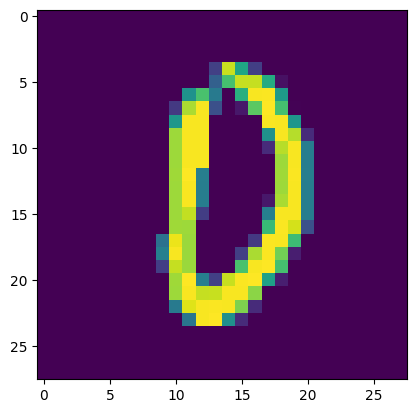

In [77]:
def visualize_predictor(predictor, ds, idx, device):
    context, actions, outcomes = ds[idx]
    context, actions, outcomes = context.to(device), actions.to(device), outcomes.to(device)
    context, actions, outcomes = context.unsqueeze(0), actions.unsqueeze(0), outcomes.unsqueeze(0)

    with torch.no_grad():
        pred = predictor(context, actions)

    plt.imshow(context.squeeze().cpu().numpy())
    print(actions)
    print(pred, outcomes)

base_ds = MNISTDataset()
visualize_predictor(predictor, base_ds, int(0.9 * len(base_ds)) + 10, "cuda:0")

In [78]:
factory = DeepNNPrescriptorFactory(**config["prescriptor_params"])
best_results = pd.read_csv(results_dir / f"{len(list(results_dir.glob("*.csv")))}.csv")
best_model = best_results.iloc[0]["cand_id"]

model = factory.load(results_dir / f"{best_model.split('_')[0]}" / f"{best_model}")

In [79]:
train_indices = list(range(int(0.8 * len(eval_ds))))
test_indices = list(range(int(0.8 * len(eval_ds)), len(eval_ds)))
test_dl = DataLoader(Subset(eval_ds, test_indices), batch_size=16, shuffle=False)
correct = 0
for encoded_context, actions, outcomes in test_dl:
    encoded_context, actions = encoded_context.to(device), actions.to(device)
    pred_actions = (model.forward(encoded_context) > 0.5).int().squeeze()
    correct += torch.sum(pred_actions == actions).item()

print(correct / len(test_indices))

0.9721666666666666


0.9999988079071045 1.0


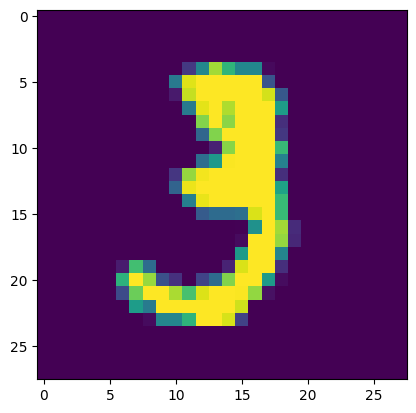

In [80]:
def visualize_prescriptor(prescriptor, base_ds, encoded_ds, idx):
    encoded_context, actions, _ = encoded_ds[idx]
    encoded_context, actions = encoded_context.to(device), actions.to(device)
    encoded_context, actions = encoded_context.unsqueeze(0), actions.unsqueeze(0)
    with torch.no_grad():
        pred = prescriptor.forward(encoded_context)

    plt.imshow(base_ds[idx][0].squeeze().cpu().numpy())
    print(pred.item(), actions.item())

visualize_prescriptor(model, base_ds, eval_ds, 10)